In [43]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import nltk
from nltk.corpus import stopwords
import time
from streamz import Stream
from collections import deque

In [2]:
#Importar datos
df = pd.read_csv("../data/cleaned_comments.csv")

# Parsear como UTC
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Convertir a zona local
df['published_at'] = df['published_at'].dt.tz_convert('America/Bogota')

# Establecer el índice temporal ordenado
df = df.set_index('published_at').sort_index()

In [3]:
# Ventana mensual: inician el 01 de cada mes, se mueve al inicio de cada mes
monthly_groups = (
    df['cleaned_comment']
      .resample('MS')
      .apply(lambda x: " ".join(x.astype(str)))
)

# Ventana semanal: inician el 01 de enero, se mueve cada 7 días
anchor = pd.Timestamp(df.index.min().year, 1, 1, tz=df.index.tz)

weekly_groups = (
    df['cleaned_comment']
      .resample('7D', origin=anchor, label='left', closed='left')
      .apply(lambda x: " ".join(x.astype(str)))
)

# Aparecen datos desde el 01-01 ya que agrupa todo el mes
print(monthly_groups.head())
# Aparecen datos desde el 01-15 ya que antes no hay comentarios
print(weekly_groups.head())


published_at
2025-01-01 00:00:00-05:00    juanita hampón creer ordenar patrona akmed pat...
2025-02-01 00:00:00-05:00    hablar méxico aaaaah nooo país méxico igualito...
2025-03-01 00:00:00-05:00    pasar acento país cambiar presentar noticia ja...
2025-04-01 00:00:00-05:00    crisis noticia colombiano hijo díficil mantene...
2025-05-01 00:00:00-05:00    gracia rtvc hermosurar inteligencia periodista...
Freq: MS, Name: cleaned_comment, dtype: object
published_at
2025-01-15 00:00:00-05:00    juanita hampón creer ordenar patrona akmed pat...
2025-01-22 00:00:00-05:00    escribir youtube bloquea saber petro armar gue...
2025-01-29 00:00:00-05:00    payaso petro saquen petro zurdo arrodillado de...
2025-02-05 00:00:00-05:00    desastrar gobierno dios poner reyes quitar rey...
2025-02-12 00:00:00-05:00    presidente uribir mario corino quintero chupar...
Freq: 7D, Name: cleaned_comment, dtype: object


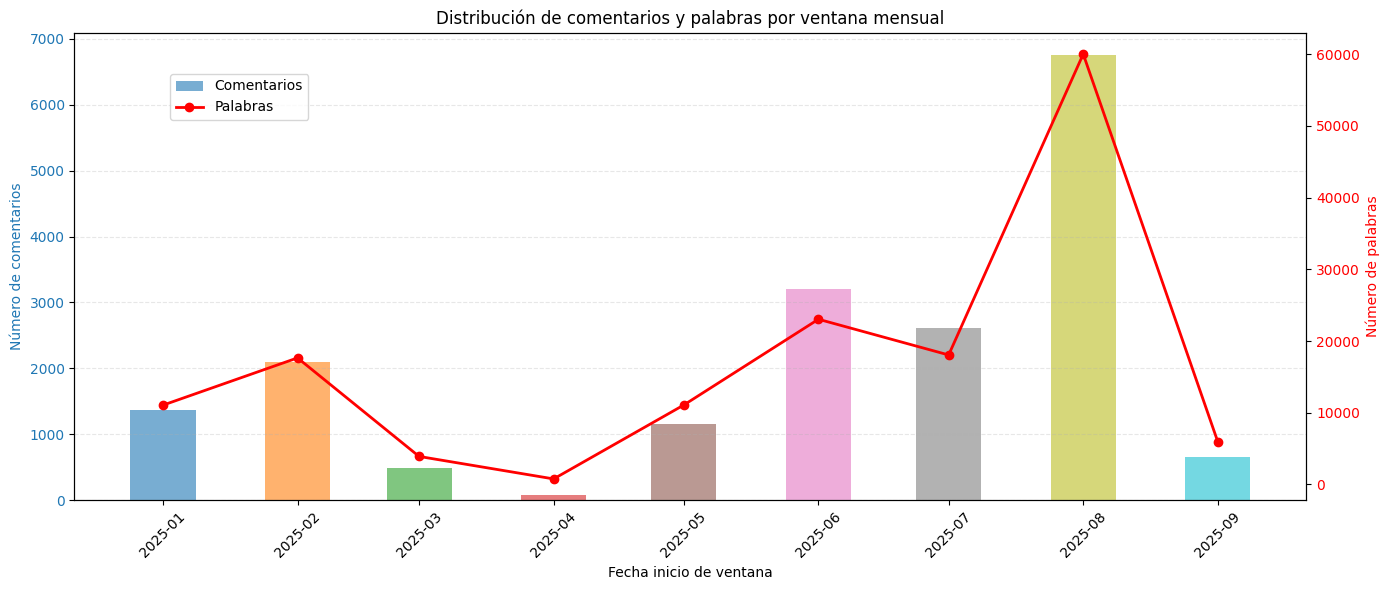

In [4]:
# Contar comentarios y palabras por ventana
monthly_comments = df['cleaned_comment'].resample('MS').size()
monthly_words = monthly_groups.apply(lambda x: len(x.split()))

# Crear colores para cada mes
months = sorted(monthly_comments.index.month.unique())
colors = cm.tab10(np.linspace(0, 1, len(months)))
color_dict = dict(zip(months, colors))

# Asignar color a cada barra mensual según el mes
bar_colors = [color_dict[d.month] for d in monthly_comments.index]

# Crear figura con doble eje Y
fig, ax1 = plt.subplots(figsize=(14,6))

# Eje Y izquierdo: Número de comentarios
ax1.bar(monthly_comments.index, monthly_comments.values, width=15, 
        color=bar_colors, alpha=0.6, label='Comentarios')
ax1.set_xlabel("Fecha inicio de ventana")
ax1.set_ylabel("Número de comentarios", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)

# Eje Y derecho: Número de palabras
ax2 = ax1.twinx()
ax2.plot(monthly_words.index, monthly_words.values, color='red', 
         marker='o', linewidth=2, label='Palabras')
ax2.set_ylabel("Número de palabras", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y leyendas
plt.title("Distribución de comentarios y palabras por ventana mensual")
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
ax1.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

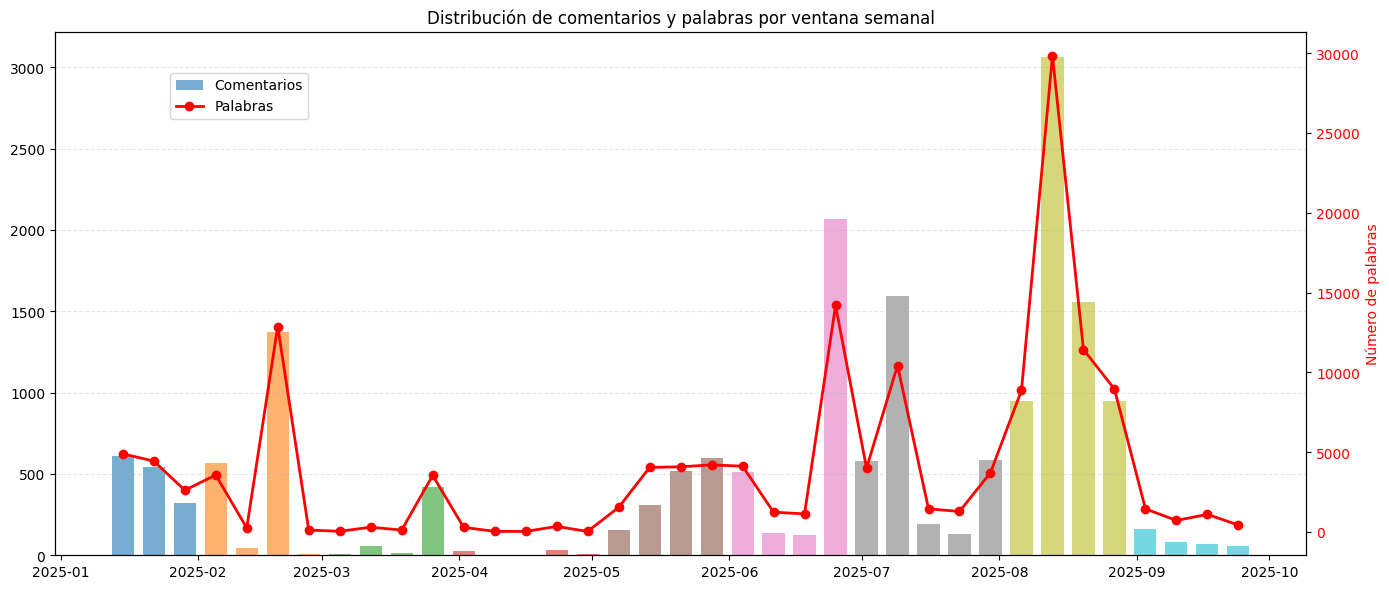

In [5]:
anchor = pd.Timestamp(df.index.min().year, 1, 1, tz=df.index.tz)

# 1) Comentarios por semana: mismos buckets de 7D anclados al 01-ene
weekly_comments = (
    df['cleaned_comment']
      .resample('7D', origin=anchor, label='left', closed='left')
      .size()
      .asfreq('7D')            # incluye semanas vacías (0)
)

# 2) Palabras por semana: reindexar para que comparta exactamente el mismo índice
weekly_words = (
    weekly_groups
      .reindex(weekly_comments.index, fill_value='')  # alinea semanas (vacías = '')
      .apply(lambda x: len(x.split()))
)

# 3) Colores por mes (mes del inicio de la semana)
months = pd.Index(weekly_comments.index.month)
uni_months = sorted(pd.unique(months))
colors = cm.tab10(np.linspace(0, 1, len(uni_months)))
color_dict = dict(zip(uni_months, colors))
bar_colors = [color_dict[m] for m in months]

# 4) Plot (ya alineados)
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.bar(weekly_comments.index, weekly_comments.values, width=5,
        color=bar_colors, alpha=0.6, label='Comentarios')
ax2 = ax1.twinx()
ax2.plot(weekly_words.index, weekly_words.values, color='red',
         marker='o', linewidth=2, label='Palabras')
ax2.set_ylabel("Número de palabras", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y leyendas
plt.title("Distribución de comentarios y palabras por ventana semanal")
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
ax1.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

def top_terms_by_window(groups, top_n=5, stopwords=None, window_name="ventana"):
    """
    - Ordena el índice temporal.
    - Soporta ventanas vacías: vectoriza solo donde hay texto y luego reindexa,
      preservando todas las ventanas (las vacías quedan en 0).
    - Maneja el caso de vocabulario reducido (top_n > n_terms).
    """
    # 0) Asegurar tipo str, NaN→'' y orden temporal
    docs = pd.Series(groups, copy=True)
    docs = docs.fillna('').astype(str)
    docs = docs.sort_index()

    original_index = docs.index

    # 1) Detectar ventanas con texto no vacío (tras strip)
    mask_nonempty = docs.str.strip().astype(bool)
    if mask_nonempty.sum() == 0:
        raise ValueError("No hay ventanas con texto no vacío para vectorizar.")

    docs_nonempty = docs[mask_nonempty]

    # 2) Conteo simple
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()

    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿textos vacíos o solo stopwords?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )

    # 3) Selección de top terms por frecuencia global
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # 4) Reindexar a TODAS las ventanas (vacías → 0) para graficar continuo
    counts_df = (
        counts_df_nonempty
        .reindex(original_index, fill_value=0)
        .loc[:, top_terms]
    )

    # 5) Gráfico de frecuencias
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia {window_name} de los {k} términos más frecuentes")
    plt.xlabel("Ventana de tiempo")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) TF-IDF restringido al mismo vocabulario (top_terms)
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )

    tfidf_df = (
        tfidf_df_nonempty
        .reindex(original_index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # 7) Gráfico de TF-IDF
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF {window_name} de los {k} términos más frecuentes")
    plt.xlabel("Ventana de tiempo")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


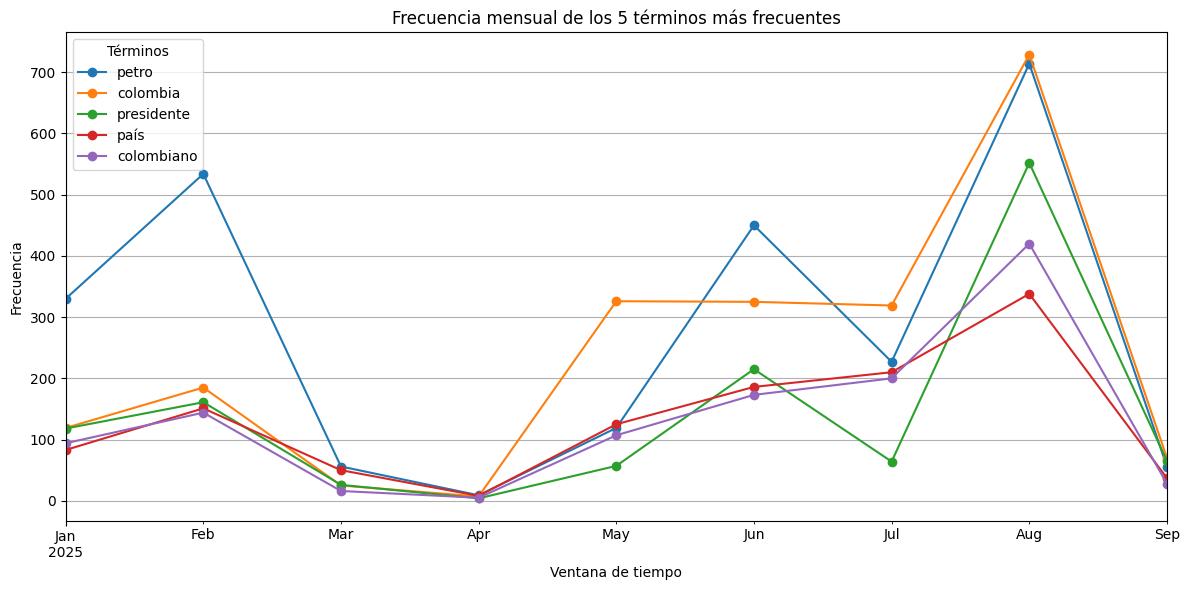

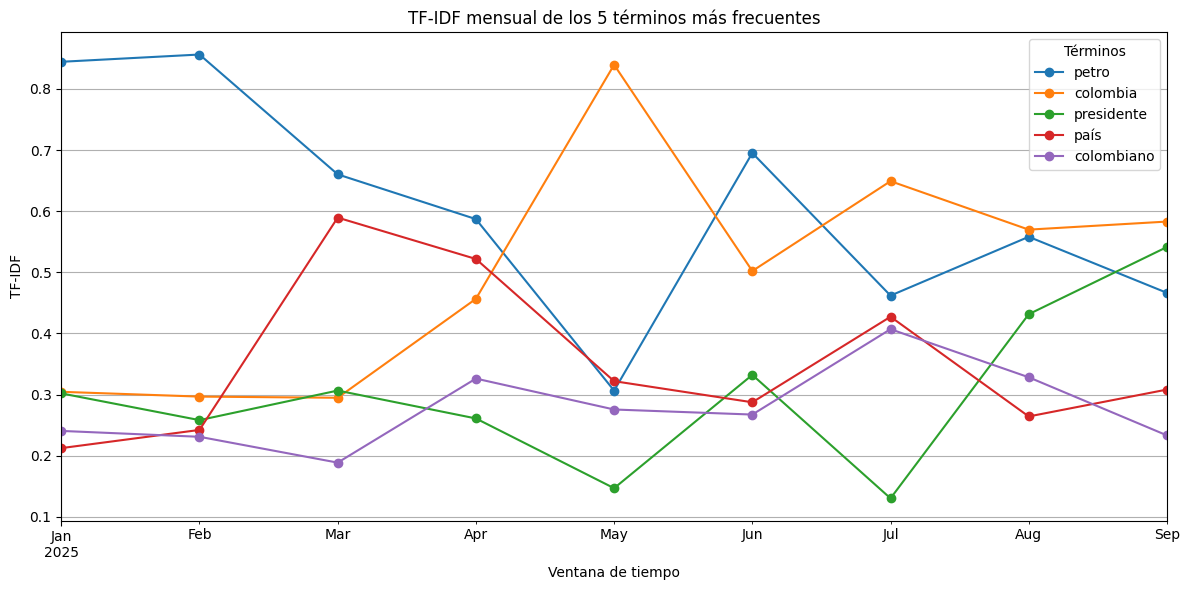

In [7]:
# Ventanas mensuales
counts_monthly, tfidf_monthly = top_terms_by_window(
    monthly_groups,
    top_n=5,
    stopwords=stopwords_es,
    window_name="mensual"
)

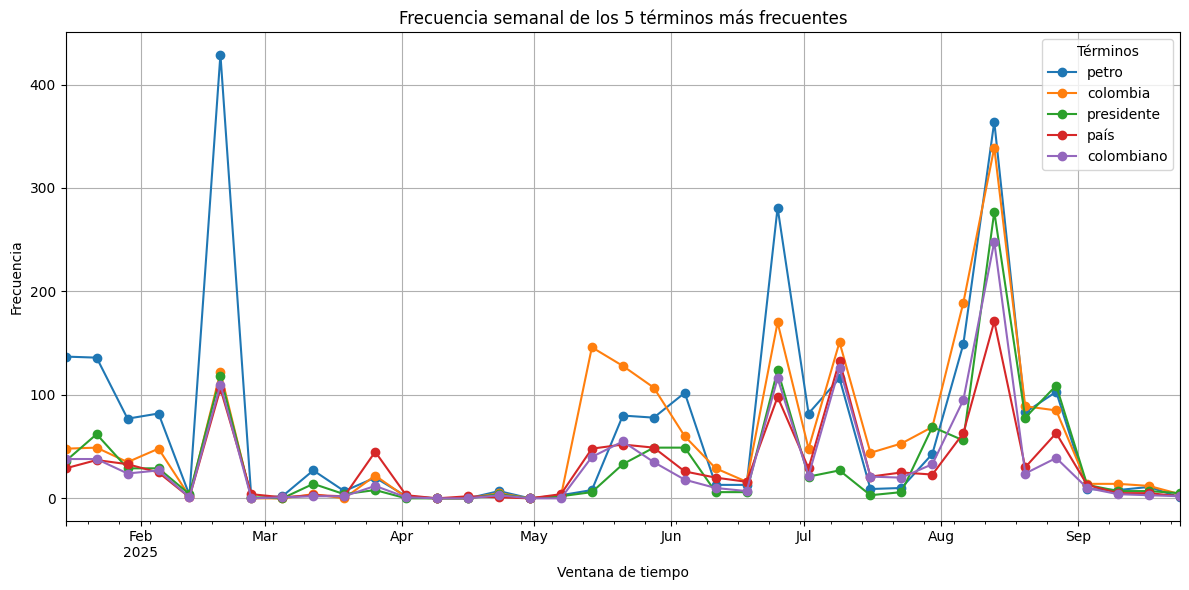

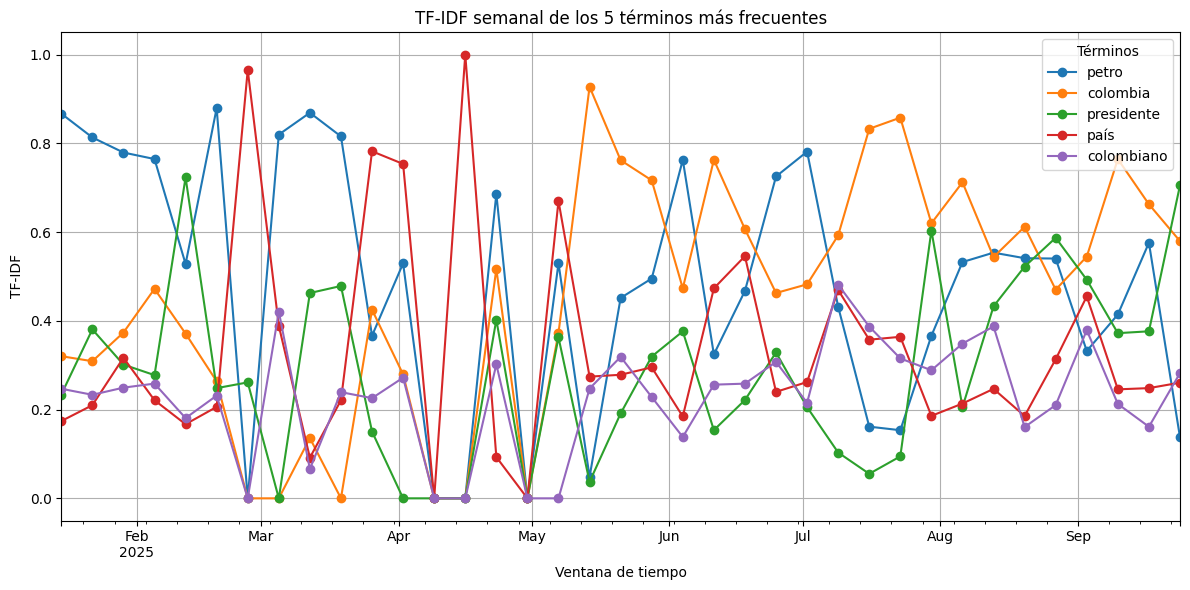

In [8]:
# Ventanas semanales
counts_weekly, tfidf_weekly = top_terms_by_window(
    weekly_groups,
    top_n=5,
    stopwords=stopwords_es,
    window_name="semanal"
)

In [9]:
def top_terms_by_days(
    df: pd.DataFrame,
    start_date,
    end_date,
    top_n: int = 5,
    stopwords=None,
    text_col: str = "cleaned_comment",
    datetime_col: str = "published_at",
):
    """
    Calcula frecuencias y TF-IDF de los top_n términos por DÍA
    en el rango [start_date, end_date] (incluyente). Incluye días sin datos.

    Retorna:
      counts_top (DataFrame): Frecuencia por día (una fila por día) de los top_n términos.
      tfidf_top  (DataFrame): TF-IDF por día de los mismos términos.
    """

    # --- 0) Asegurar índice datetime y orden
    if df.index.name != datetime_col:
        s = df.set_index(datetime_col)[text_col].copy()
    else:
        s = df[text_col].copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index().astype(str)

    if s.empty:
        raise ValueError("No hay datos con índice temporal válido.")

    idx_tz = s.index.tz

    # --- 1) Alinear fechas de entrada a la tz del índice (o naive si el índice lo es)
    def _align(ts):
        ts = pd.to_datetime(ts, errors="coerce")
        if pd.isna(ts):
            return None
        if idx_tz is None:
            return ts.tz_localize(None) if ts.tzinfo is not None else ts
        return ts.tz_localize(idx_tz) if ts.tzinfo is None else ts.tz_convert(idx_tz)

    start_ts = _align(start_date)
    end_ts   = _align(end_date)
    if start_ts is None or end_ts is None:
        raise ValueError("start_date o end_date no son fechas válidas.")
    if start_ts > end_ts:
        raise ValueError("start_date no puede ser mayor que end_date.")

    # Normalizar a medianoche para cubrir días completos
    start_day = start_ts.normalize()
    end_day   = end_ts.normalize()

    # --- 2) Recortar al rango de días (incluyente)
    # Usamos < end_day+1D para incluir todo el último día completo
    right_exclusive = end_day + pd.Timedelta(days=1)
    s_range = s[(s.index >= start_day) & (s.index < right_exclusive)]

    # Índice diario continuo (todas las fechas del rango, incluso vacías)
    daily_index = pd.date_range(start=start_day, end=end_day, freq="D", tz=idx_tz)

    # --- 3) Agregar por día (texto concatenado) y rellenar días vacíos
    daily_groups = (
        s_range.resample("D", origin=start_day, label="left", closed="left")
              .apply(lambda x: " ".join(x.astype(str)))
              .reindex(daily_index, fill_value="")
    )

    # --- 4) Vectorización robusta (evita vocabulario vacío)
    docs = daily_groups.fillna("").astype(str)
    mask = docs.str.strip().astype(bool)
    if mask.sum() == 0:
        raise ValueError("Todos los días del rango están vacíos (sin texto).")

    docs_nonempty = docs[mask]

    # Conteos
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()
    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿todo son stopwords o textos vacíos?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # Reinsertar días vacíos como 0 para eje continuo
    counts_df = (
        counts_df_nonempty
        .reindex(docs.index, fill_value=0)
        .loc[:, top_terms]
    )

    # --- 5) Gráfico de frecuencias por día
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia diaria de los {k} términos más frecuentes ({start_day:%Y-%m-%d} → {end_day:%Y-%m-%d})")
    plt.xlabel("Día")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # TF-IDF sobre el mismo vocabulario
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )
    tfidf_df = (
        tfidf_df_nonempty
        .reindex(docs.index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # --- 6) Gráfico de TF-IDF por día
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF diario de los {k} términos más frecuentes ({start_day:%Y-%m-%d} → {end_day:%Y-%m-%d})")
    plt.xlabel("Día")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

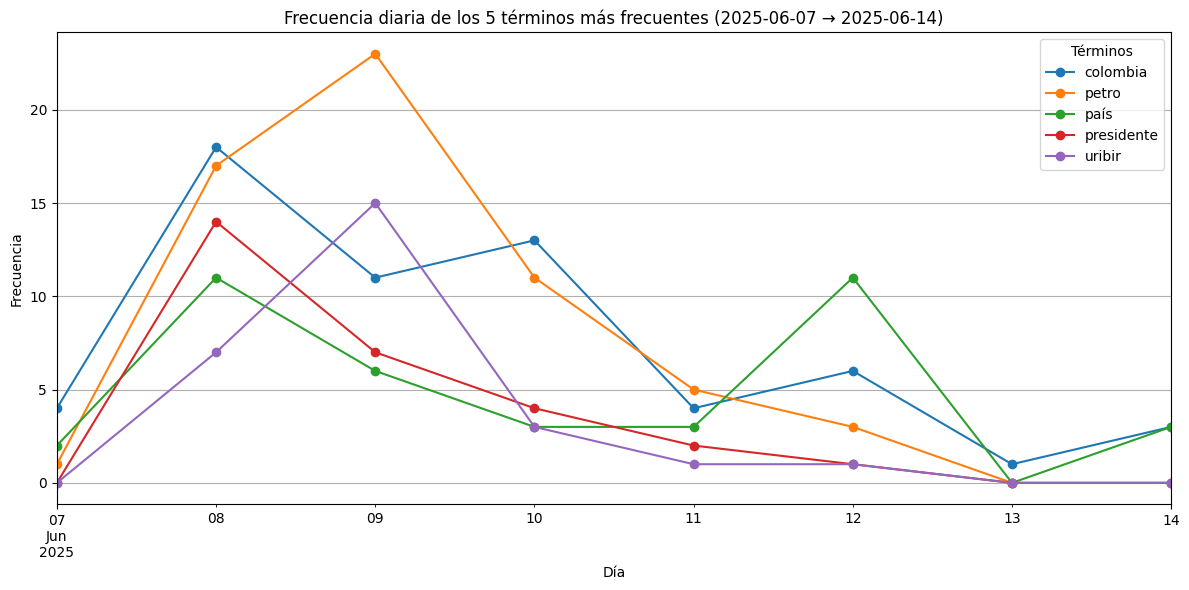

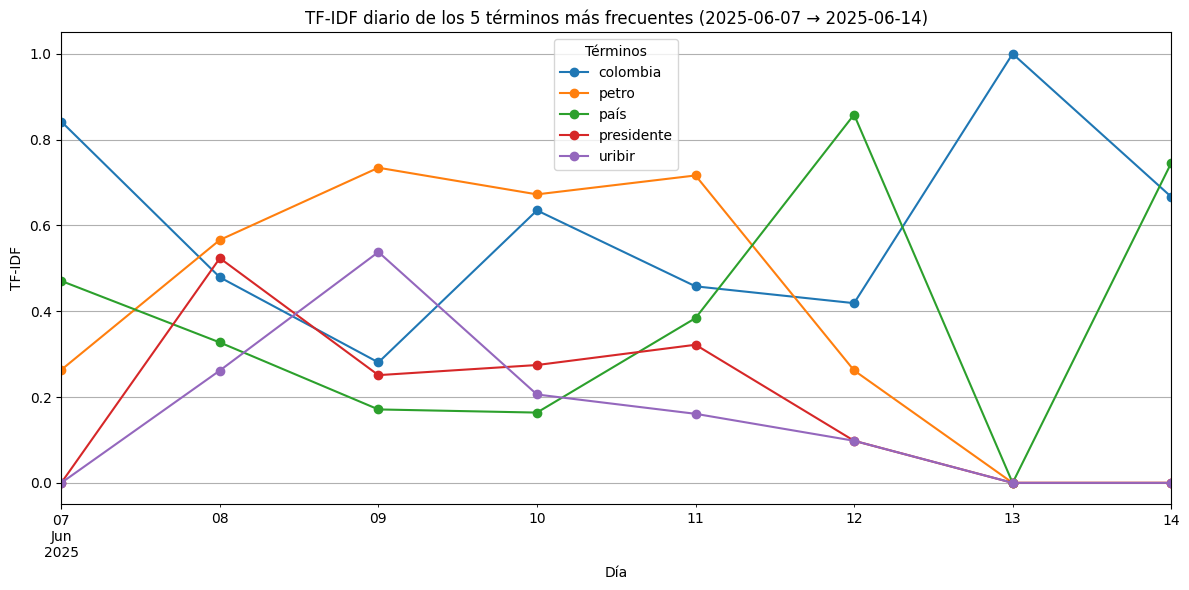

In [10]:
# Rango de fechas del atentado a Miguel Uribe
counts_daily, tfidf_daily = top_terms_by_days(
    df,
    start_date="2025-06-07",
    end_date="2025-06-14",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

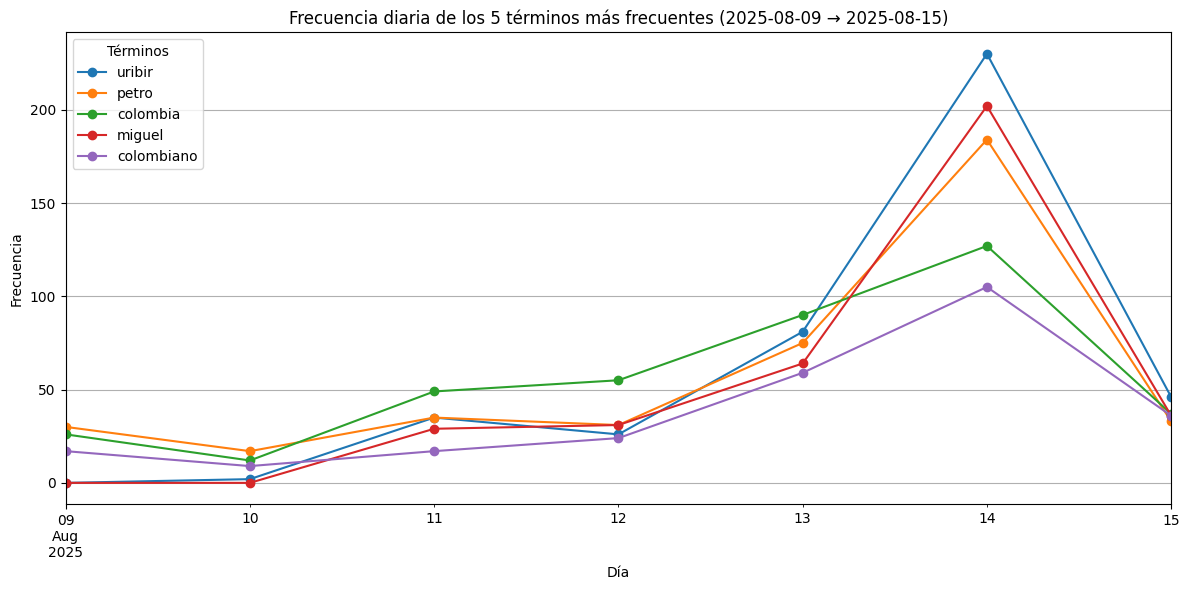

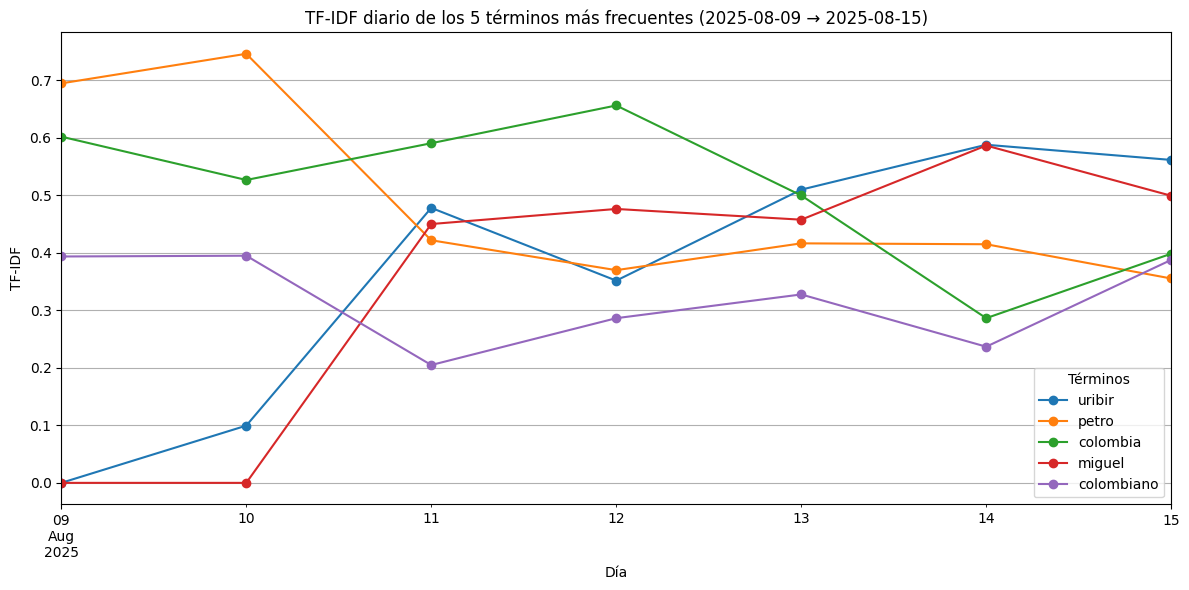

In [ ]:
# Rango de fechas del fallecimiento de Miguel Uribe a su funeral (dos días antes y dos días después)
counts_daily, tfidf_daily = top_terms_by_days(
    df,
    start_date="2025-08-09",
    end_date="2025-08-15",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

In [12]:
def top_terms_24h(
    df: pd.DataFrame,
    day,                              # "YYYY-MM-DD" o datetime-like
    top_n: int = 5,
    stopwords=None,
    text_col: str = "cleaned_comment",
    datetime_col: str = "published_at",
):
    """
    Calcula frecuencias y TF-IDF por HORA para un día dado (24 horas exactas).
    Incluye horas sin datos (se muestran como 0) para un eje continuo.

    Parámetros
    ----------
    df : DataFrame con columnas [datetime_col, text_col]
    day : str | datetime-like
        Día a analizar. Ej: "2025-08-11".
        La ventana será [day 00:00, day+1 00:00).
    top_n : int
        Número de términos a reportar.
    stopwords : list | None
        Stopwords a remover en la vectorización.
    text_col : str
        Nombre de la columna de texto.
    datetime_col : str
        Nombre de la columna datetime.

    Retorna
    -------
    counts_top : DataFrame
        Frecuencias por hora (24 filas) de los términos top_n.
    tfidf_top : DataFrame
        TF-IDF por hora (24 filas) de los términos top_n.
    """

    # --- 0) Asegurar índice datetime y tz coherente con el día
    if df.index.name != datetime_col:
        s = df.set_index(datetime_col)[text_col].copy()
    else:
        s = df[text_col].copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index().astype(str)

    if s.empty:
        raise ValueError("No hay datos con índice temporal válido.")

    # Tz del índice (None si es naive)
    idx_tz = s.index.tz

    # Normalizar "day" a la misma tz del índice
    day_ts = pd.to_datetime(day, errors="coerce")
    if pd.isna(day_ts):
        raise ValueError("El parámetro 'day' no es una fecha válida.")
    if idx_tz is None:
        # índice naive → asegurar day naive
        if day_ts.tzinfo is not None:
            day_ts = day_ts.tz_localize(None)
    else:
        # índice tz-aware → alinear day a esa tz
        if day_ts.tzinfo is None:
            day_ts = day_ts.tz_localize(idx_tz)
        else:
            day_ts = day_ts.tz_convert(idx_tz)

    start_ts = day_ts.normalize()                  # 00:00 de ese día (en la tz del índice)
    end_ts   = start_ts + pd.Timedelta(days=1)     # 24h semiabierto

    # --- 1) Recortar al día solicitado
    s_day = s.loc[start_ts:end_ts - pd.Timedelta(microseconds=1)]
    # Creamos el índice horario completo (24 marcas) para eje continuo
    hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")

    # --- 2) Agregar por hora (texto concatenado) y rellenar horas vacías
    hourly_groups = (
        s_day.resample("H", origin=start_ts, label="left", closed="left")
            .apply(lambda x: " ".join(x.astype(str)))
            .reindex(hourly_index, fill_value="")
    )

    # --- 3) Vectorización robusta
    docs = hourly_groups.fillna("").astype(str)
    mask = docs.str.strip().astype(bool)
    if mask.sum() == 0:
        raise ValueError("Las 24 horas están vacías (no hay texto en ese día).")

    docs_nonempty = docs[mask]

    # Conteos
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()
    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿todo son stopwords o textos vacíos?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # Reinsertar horas vacías como 0 para eje continuo de 24 puntos
    counts_df = (
        counts_df_nonempty
        .reindex(docs.index, fill_value=0)
        .loc[:, top_terms]
    )

    # --- 4) Gráfico de frecuencias (24 horas)
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia horaria de los {k} términos más frecuentes ({start_ts:%Y-%m-%d})")
    plt.xlabel("Hora")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # TF-IDF sobre el mismo vocabulario
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )
    tfidf_df = (
        tfidf_df_nonempty
        .reindex(docs.index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # --- 5) Gráfico TF-IDF (24 horas)
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF horario de los {k} términos más frecuentes ({start_ts:%Y-%m-%d})")
    plt.xlabel("Hora")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

C:\Users\laura\AppData\Local\Temp\ipykernel_17720\2768192226.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\2768192226.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s_day.resample("H", origin=start_ts, label="left", closed="left")


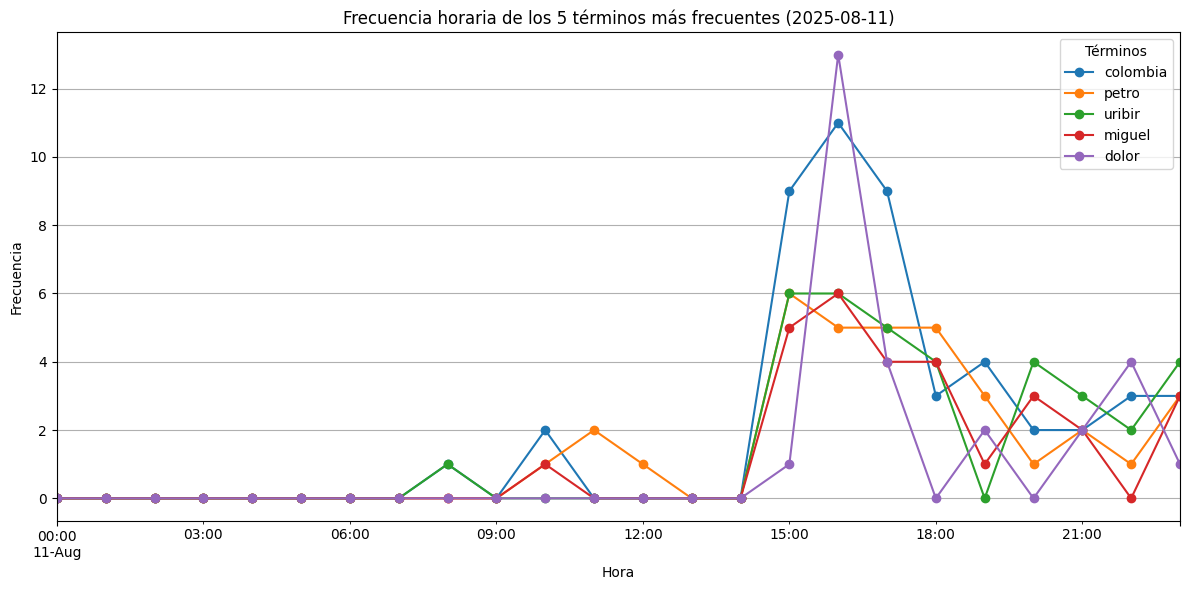

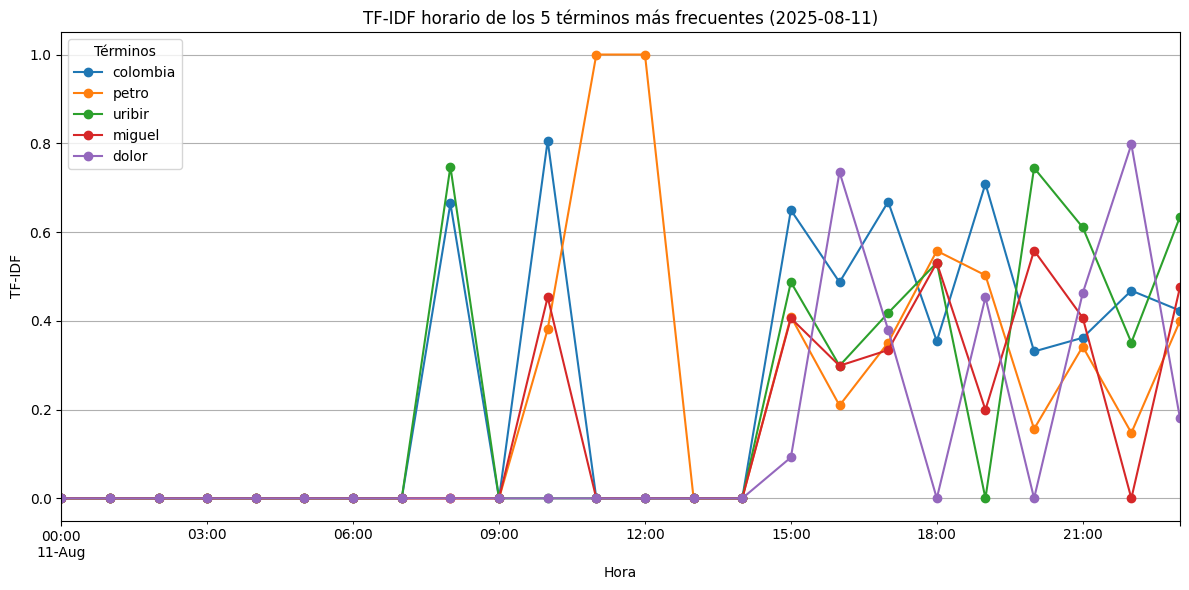

In [13]:
# Día del fallecimiento de Miguel Uribe
counts_24h, tfidf_24h = top_terms_24h(
    df,
    day="2025-08-11",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

C:\Users\laura\AppData\Local\Temp\ipykernel_17720\2768192226.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\2768192226.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s_day.resample("H", origin=start_ts, label="left", closed="left")


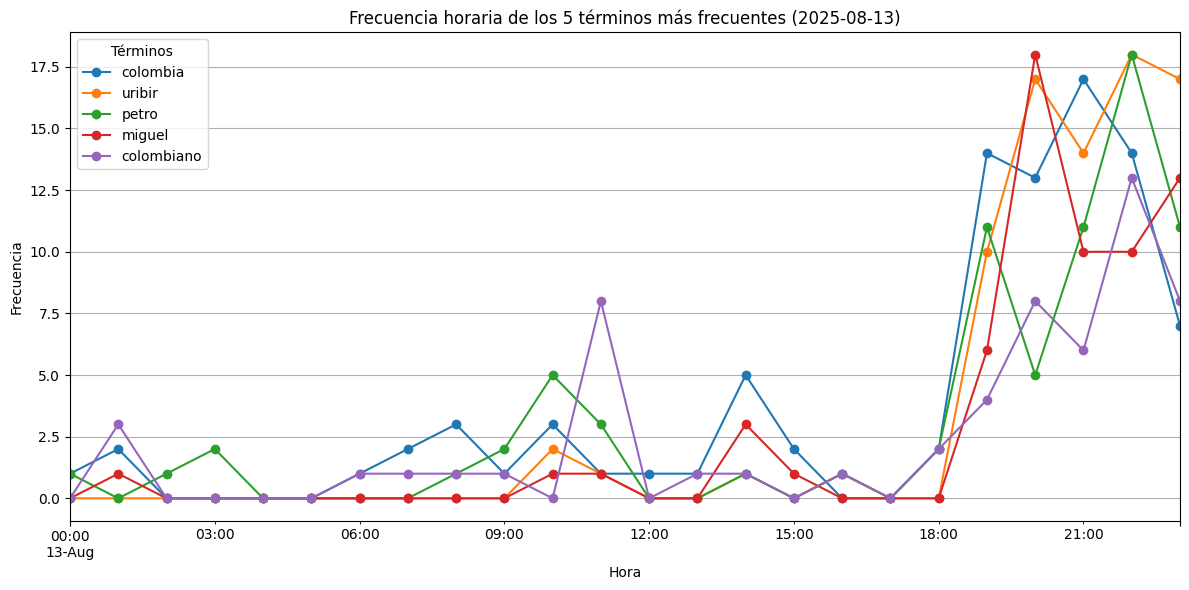

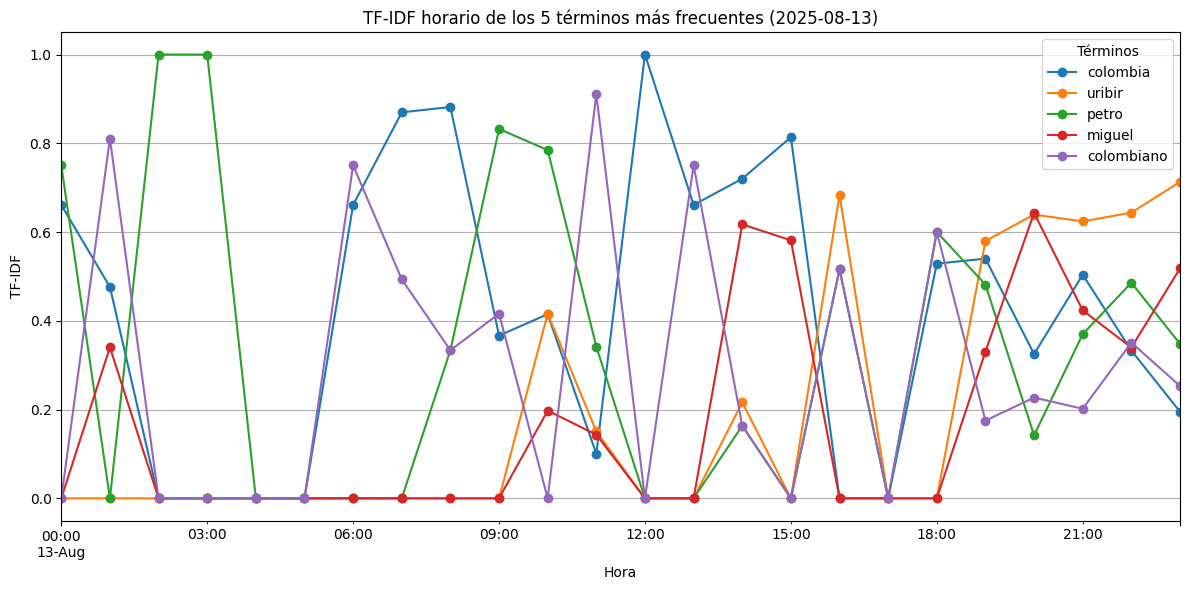

In [62]:
# Día del funeral de Miguel Uribe
counts_24h, tfidf_24h = top_terms_24h(
    df,
    day="2025-08-13",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

In [ ]:
def compute_top_terms_window(s_window: pd.Series, top_n=10, stopwords=None, gran='1H'):
    """
    - Agrupa por 'gran' ('1H' o '1D') para las curvas.
    - top_terms por frecuencia absoluta global de la ventana.
    - TF-IDF restringido a ese vocabulario.
    """
    docs = s_window.groupby(pd.Grouper(freq=gran, label='left', closed='left')) \
                   .apply(lambda x: " ".join(x.astype(str)))
    docs = docs.fillna("").astype(str)
    mask = docs.str.strip().astype(bool)
    if mask.sum() == 0:
        return None, None, None

    docs_nonempty = docs[mask]

    # Conteos
    cv = CountVectorizer(stop_words=stopwords)
    Xc = cv.fit_transform(docs_nonempty)
    terms = cv.get_feature_names_out()
    if len(terms) == 0:
        return None, None, None

    counts_df_nonempty = pd.DataFrame(Xc.toarray(), index=docs_nonempty.index, columns=terms)
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # Reinsertar vacíos (0) para eje continuo
    counts_df = counts_df_nonempty.reindex(docs.index, fill_value=0).loc[:, top_terms]

    # TF-IDF
    tv = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    Xt = tv.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(Xt.toarray(), index=docs_nonempty.index, columns=tv.get_feature_names_out())
    tfidf_df = tfidf_df_nonempty.reindex(docs.index, fill_value=0.0).loc[:, top_terms]

    return counts_df, tfidf_df, top_terms

def simulate_with_streamz(
    df, start, end, *, step='1H', window='3H', top_n=10, stopwords=None, gran='1H', speed=None
):
    source = Stream()
    buf = deque()
    W = pd.to_timedelta(window)
    step_td = pd.to_timedelta(step)

    def on_tick(t_now):
        left = t_now - W
        # descarta lo que sale de la ventana
        while buf and buf[0][0] <= left:
            buf.popleft()

        if not buf:
            return None

        s = pd.Series([txt for _, txt in buf],
                      index=pd.DatetimeIndex([ts for ts, _ in buf],
                                             tz=getattr(df.index, "tz", None))).sort_index()

        counts, tfidf, top = compute_top_terms_window(s, top_n=top_n, stopwords=stopwords, gran=gran)
        return {"t_now": t_now, "counts": counts, "tfidf": tfidf, "top_terms": list(top)}

    out = source.map(on_tick)

    def run():
        data = df.copy()
        if data.index.name != 'published_at':
            data = data.set_index('published_at')
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index, errors='coerce')
        data = data[~data.index.isna()].sort_index()
        tz = data.index.tz

        start_ts = pd.to_datetime(start); end_ts = pd.to_datetime(end)
        if tz is not None:
            start_ts = start_ts.tz_localize(tz) if start_ts.tzinfo is None else start_ts.tz_convert(tz)
            end_ts   = end_ts.tz_localize(tz)   if end_ts.tzinfo   is None else end_ts.tz_convert(tz)

        # (opcional) precarga para que la primera ventana esté llena
        warm_left = start_ts - W
        for ts, txt in data.loc[(data.index > warm_left) & (data.index <= start_ts), 'cleaned_comment'].items():
            buf.append((ts, str(txt)))

        t = start_ts
        while t < end_ts:
            t_next = min(t + step_td, end_ts)

            batch = data.loc[(data.index >= t) & (data.index < t_next), 'cleaned_comment']
            for ts, txt in batch.items():
                buf.append((ts, str(txt)))
                
            source.emit(t_next)

            if speed:
                time.sleep(step_td.total_seconds() / speed)
            t = t_next

    return out, run

out, run = simulate_with_streamz(
    df, start="2025-08-14 09:00", end="2025-08-14 21:00",
    step="1H", window="3H", top_n=10, stopwords=stopwords_es, gran='1H', speed=None
)

snapshots = []
out.sink(lambda snap: snap and snapshots.append(snap))
run()


C:\Users\laura\AppData\Local\Temp\ipykernel_17720\4019364124.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  W = pd.to_timedelta(window)
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\4019364124.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  step_td = pd.to_timedelta(step)
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\4019364124.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  docs = s_window.groupby(pd.Grouper(freq=gran, label='left', closed='left')) \
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\4019364124.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  docs = s_window.groupby(pd.Grouper(freq=gran, label='left', closed='left')) \
C:\Users\laura\AppData\Local\Temp\ipykernel_17720\4019364124.py:7: FutureWarning: 'H' is deprecated 

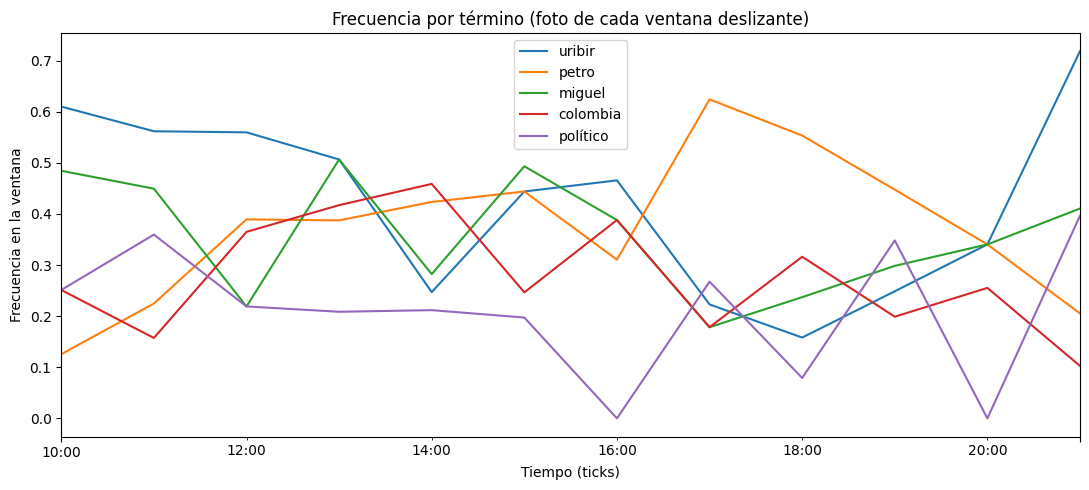

In [ ]:
def timeline_from_window_snapshots(snapshots, top_k=8, metric="counts"):
    """
    De cada snapshot toma la ÚLTIMA fila del DataFrame 'counts' (o 'tfidf')
    para representar el estado de ESA ventana en el tick t_now.
    Retorna un DataFrame indexado por t_now, columnas = términos.
    """
    rows = []
    for snap in snapshots:
        df = snap.get(metric, None)
        if df is None or not hasattr(df, "iloc") or df.empty:
            continue
        last_row = df.iloc[-1].copy()
        last_row.name = pd.to_datetime(snap["t_now"])
        rows.append(last_row)

    if not rows:
        return pd.DataFrame()

    timeline = pd.DataFrame(rows).sort_index().fillna(0)

    # Elegimos los términos más relevantes a lo largo del timeline (suma por columna)
    top_overall = timeline.sum(axis=0).sort_values(ascending=False).head(top_k).index
    return timeline.loc[:, top_overall]

# Construye la matriz (usa 'counts' para frecuencias; o 'tfidf' para intensidad-normalizada)
timeline = timeline_from_window_snapshots(snapshots, top_k=5, metric="tfidf")

plt.figure(figsize=(11, 5))
timeline.plot(ax=plt.gca())
plt.title("Frecuencia por término (foto de cada ventana deslizante)")
plt.xlabel("Tiempo (ticks)")
plt.ylabel("Frecuencia en la ventana")
plt.tight_layout()
plt.show()
